# Trees - Modelling

## PROBLEM: With given dataset, predict the probability of the payment within 90 days

This is a small sample of data (both in terms of observations and available variables) that is actually used for training our models in *****. All the IDs are replaced, and all datapoints have a slight noise added to them to avoid any chance of identification. Data is stored as a small SQLite database stored in attached `session_9-Trees.db` file. There are two tables - `dataset` and `metadata`. The data sample spans 1 year and 30k observations.

In [53]:
# Data handling and visualization
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler   
from sklearn.compose import ColumnTransformer  
from sklearn.pipeline import Pipeline  

# Model selection, training and evaluation
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  
from sklearn.linear_model import LogisticRegression  
from xgboost import XGBClassifier  
from lightgbm import LGBMClassifier  
from sklearn.model_selection import cross_validate  
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [54]:
# Connect to the database
con = sqlite3.connect('session_9-Trees.db')

# Read the tables
df_metadata = pd.read_sql_query('SELECT * FROM metadata;', con)
df_dataset = pd.read_sql_query('SELECT * FROM dataset;', con)

# Close the connection
con.close()

# Display the metadata
df_metadata

,varcode,name,var_class,entity_table
0,a8404,RatioOfCustomersAtAddressWithSuccessfullyClose...,variable,address
1,ap090,TargetAmount90Days,target,case
2,c0001,OriginalCapitalOfCaseInvoices,variable,case
3,c0015,AmountOfCase,variable,case
4,c0019,AgeOfDebt,variable,case
5,c0031,NumberOfTelephonesCI,variable,case
6,c0039,IndustryCode,variable,case
7,c0044,ClientName,variable,case
8,c9008,CustomerAge,variable,case
9,ct090,Target90Days,target,case


### Some background information on the data

The intended target for prediction is `ct090`, `case_id` is the unique identifier, `keydate` is the point in time when some event has happened in the lifecycle of a case, and also a date relative to which all of the backward looking variables and forward looking targets are calculated. In this case, it's a general purpose propensity to pay model, which means that it is a freshly registered case, where all the relevant data has been gathered and verified. In other words, `keydate` is set a few days after registration, and target `ct090` is checking for outcome in 90 days (`ap090` is a similar regression target), while all the rest of the data is only looking backwards!

Metadata gives some basic description of variables. The general naming convention is based on prefixes that define aggregation levels - `cXXXX` looking at the data of this case only, `dXXXX` looking at other cases of same debtor, `bXXXX` looking at all cases of the debtor, `aXXXX` looking at all the cases on the same address. This is not very relevant for this particular task, but gives some idea of our data setup here in ******! Note that this data selection has quite a few variables with the `dXXXX` prefix, which means that this selection is specifically looking at debtors that we already had worked with before, therefore, variable selection is much broader and models are generally better. 

One more tip on interpretation of missing values: if variable is bound by time window, e.g. `d2112 NumberOfCustomerPaymentsInLast12Months`, the `NA` value implies that there never have been any values, while `0` would mean that have been no values within bounding period (in this case 12 months). In other words, `0` and `NA` have different interpretation. It may or may not be relevant, depending on the choice of the modelling approach. 

### Some tips on the task

There is no end to seeking the perfection, and countless ways to approach this task. However, try not to approach this like a competition to crank out the highest possible accuracy metrics. What matters is the sequence and thought process - show this in illustrations and comments! Even if certain things might take too long to implement in a code, but you have a good idea where to go with this - write down your ideas! This is what matters.

Good luck!

# Solution

### 1. First look at the data



In [55]:
# Display the dataset
df_dataset.head()

,case_id,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
0,1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
1,2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
2,3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.0,748.0,0.0,48.0,NaN,3,NaN,56.84
3,4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.0,8.0,0.0,27.0,NaN,4,NaN,463.15
4,5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09


In [56]:
# Rename the columns in dataframe
dataframe = df_dataset.copy()# Copy the original DataFrame to preserve the raw data
name_mapping = dict(zip(df_metadata['varcode'], df_metadata['name']))# Create a dictionary mapping varcode to name
dataframe.rename(columns=name_mapping, inplace=True)
dataframe.head()

,case_id,keydate,Target90Days,TargetAmount90Days,OriginalCapitalOfCaseInvoices,IndustryCode,ClientName,NumberOfUnsuccessfullyClosedCustomerCasesLast36Months,AmountOfCustomerPaymentsOnAllCasesBlevel,AmountOfCustomerOpenCases,NumberOfTelephonesCI,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,AgeOfDebt,NumberOfCustomerIncomingCallDatesTee,CustomerAge,NumberOfCustomerPaymentsInLast12Months,LastOriginalClosingCodeOfCustomer,NumberOfSuccessfullyClosedCasesInLast24Months,AmountOfCase
0,1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
1,2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
2,3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.0,748.0,0.0,48.0,NaN,3,NaN,56.84
3,4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.0,8.0,0.0,27.0,NaN,4,NaN,463.15
4,5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09


### 2. Exploratory Data Analysis (EDA) and practical and business conclusions

In [57]:
# Convert 'keydate' to datetime format for easier manipulation
dataframe['keydate'] = pd.to_datetime(dataframe['keydate'])

# Create a temporal distribution of cases by month
temporal_distribution = dataframe['keydate'].dt.to_period("M").value_counts().sort_index()

# Print data types of all columns to understand the dataset structure
print("\nData Types of Columns in DataFrame:")
print(dataframe.dtypes)

# Print the temporal distribution of cases
print("\nTemporal Distribution of Cases by Month:")
print(temporal_distribution)

# Calculate and print descriptive statistics for numerical columns
print("\nDescriptive Statistics for Numerical Columns:")
print(dataframe.describe())


Data Types of Columns in DataFrame:
case_id                                                                      int64
keydate                                                             datetime64[ns]
Target90Days                                                               float64
TargetAmount90Days                                                         float64
OriginalCapitalOfCaseInvoices                                              float64
IndustryCode                                                                object
ClientName                                                                  object
NumberOfUnsuccessfullyClosedCustomerCasesLast36Months                      float64
AmountOfCustomerPaymentsOnAllCasesBlevel                                   float64
AmountOfCustomerOpenCases                                                  float64
NumberOfTelephonesCI                                                       float64
RatioOfCustomersAtAddressWithSuccessfullyClosedCas

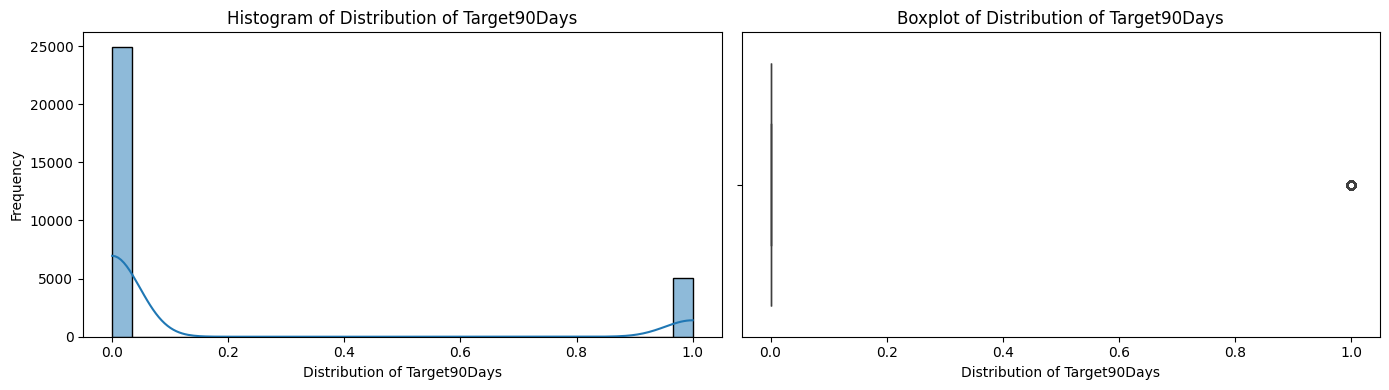

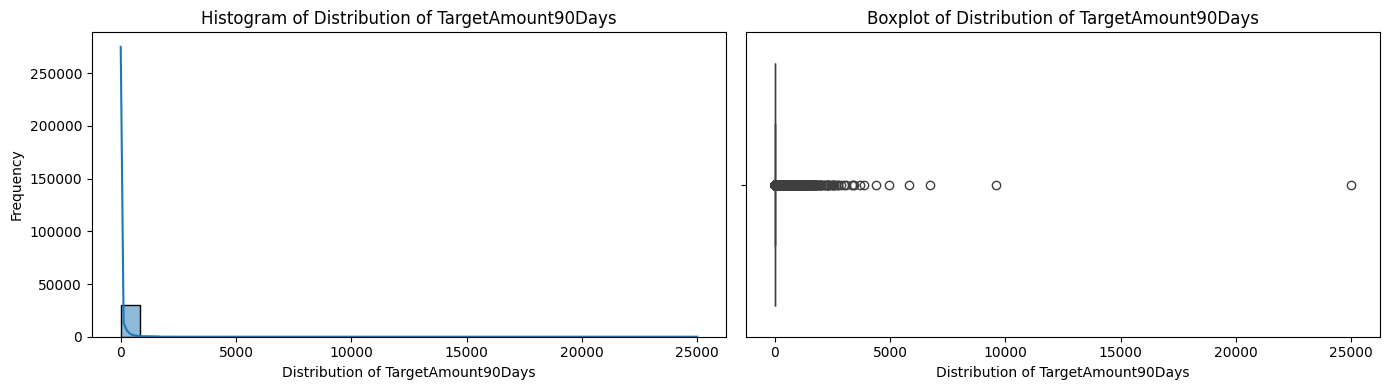

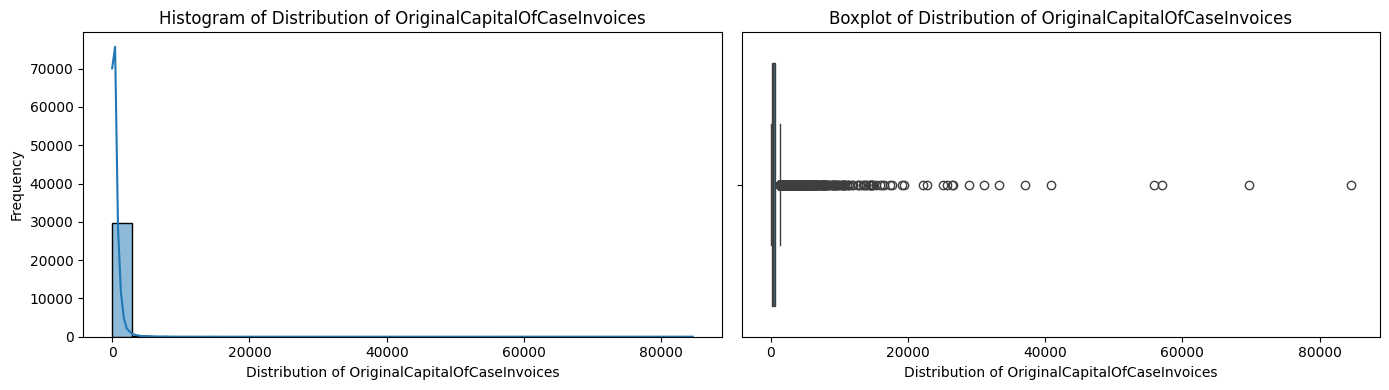

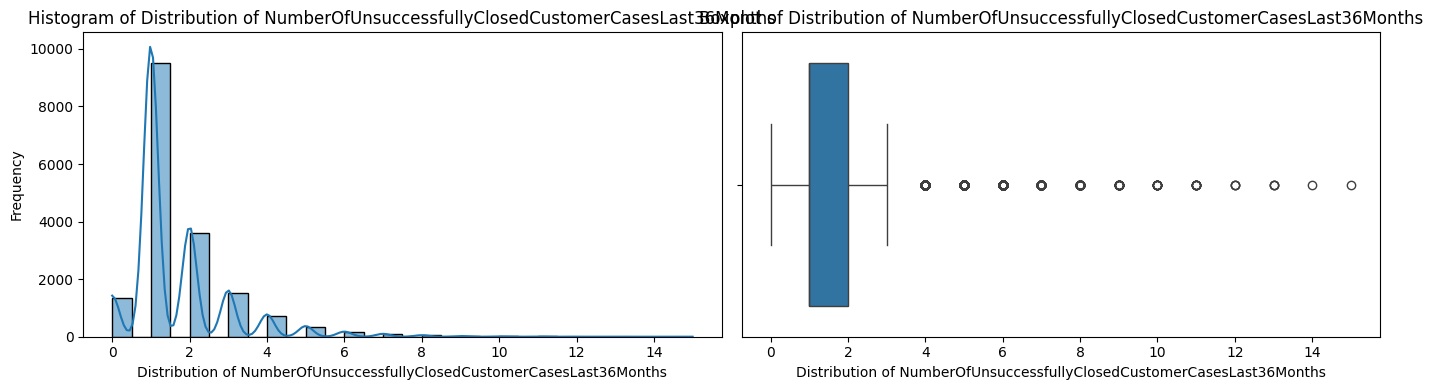

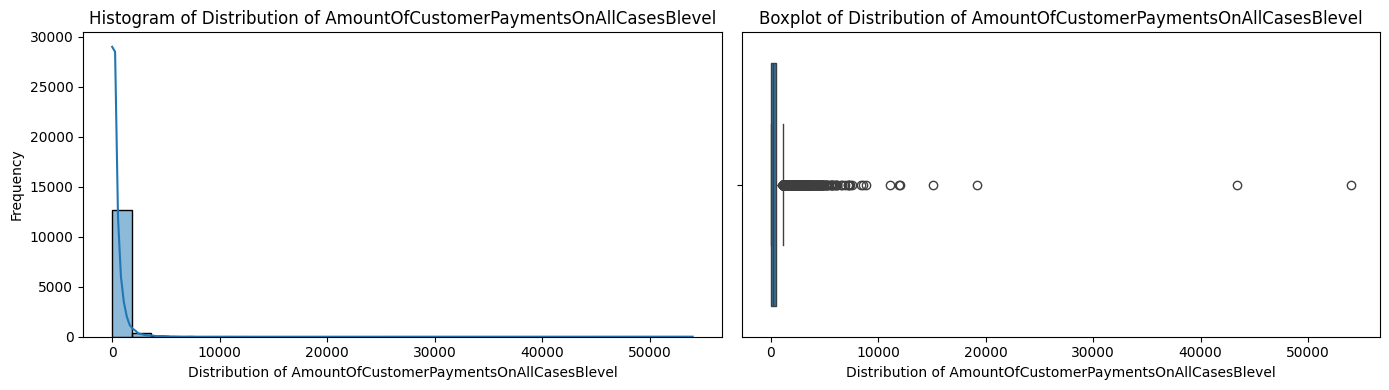

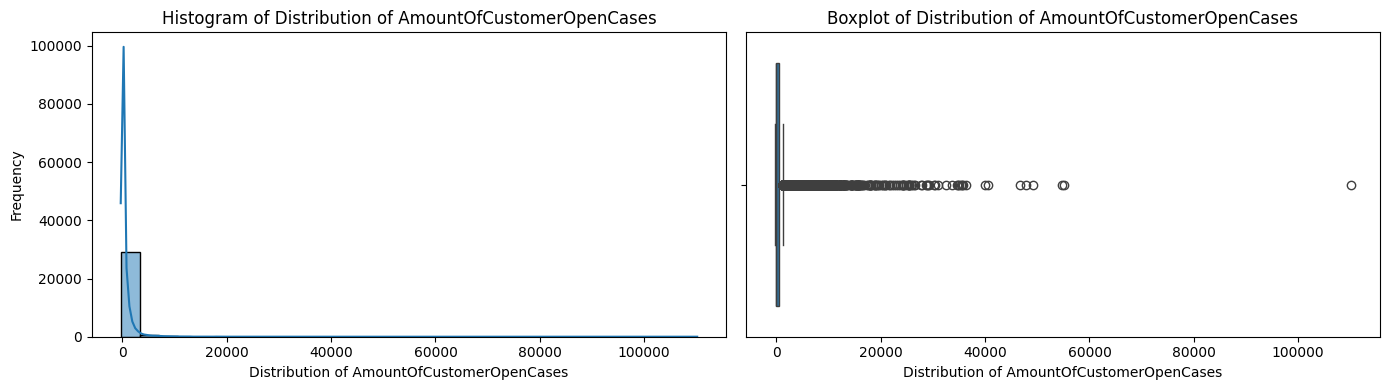

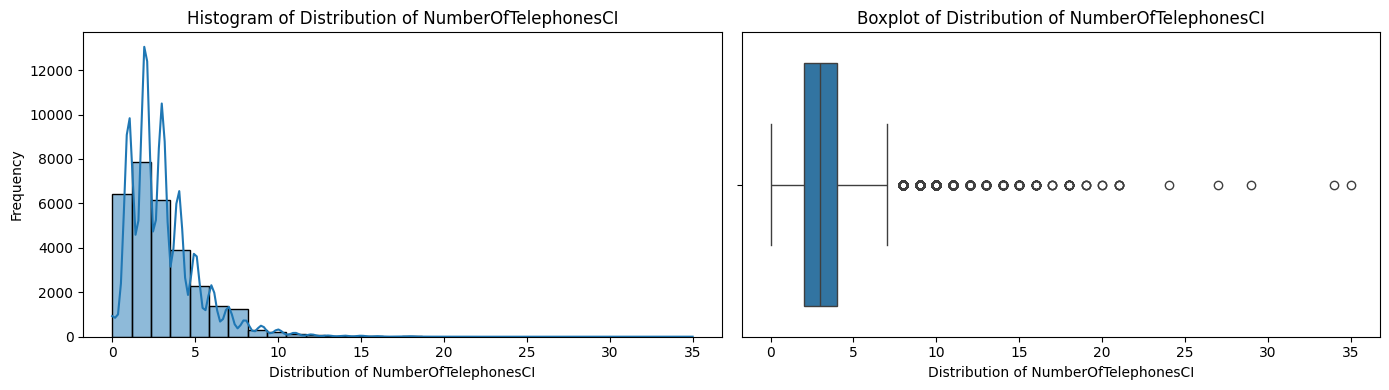

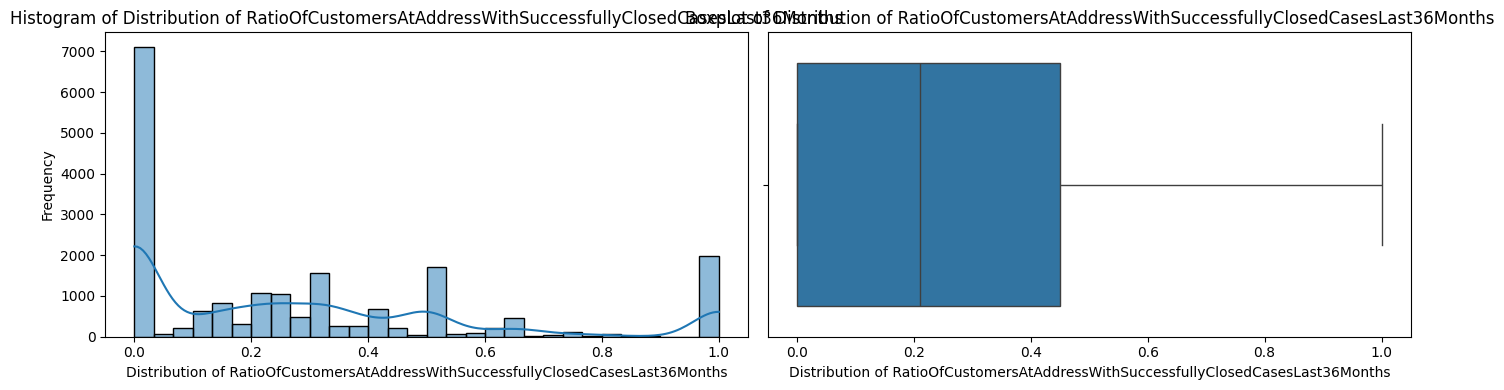

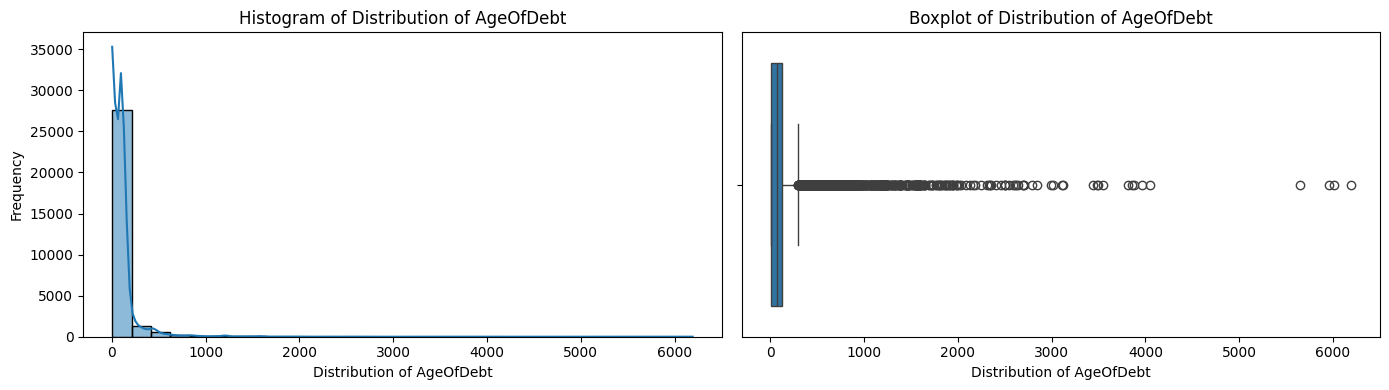

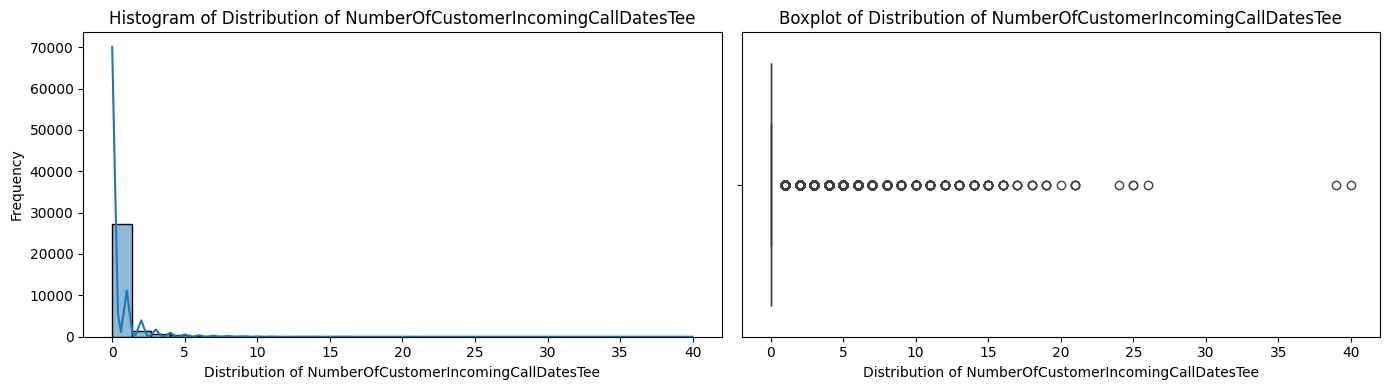

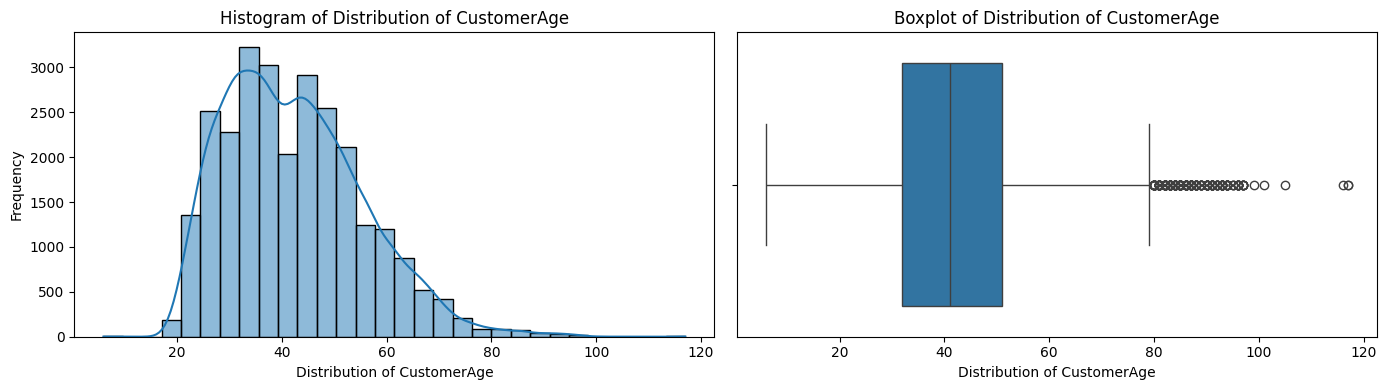

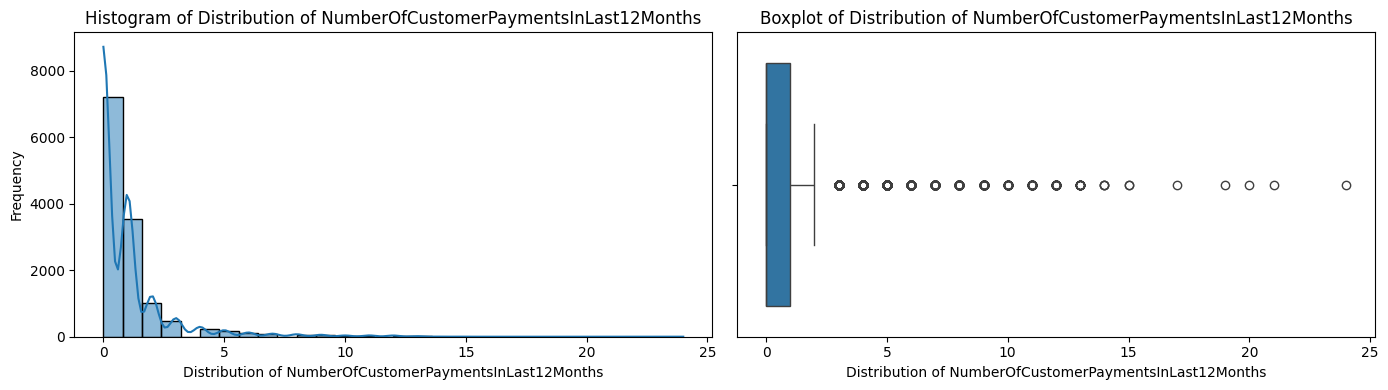

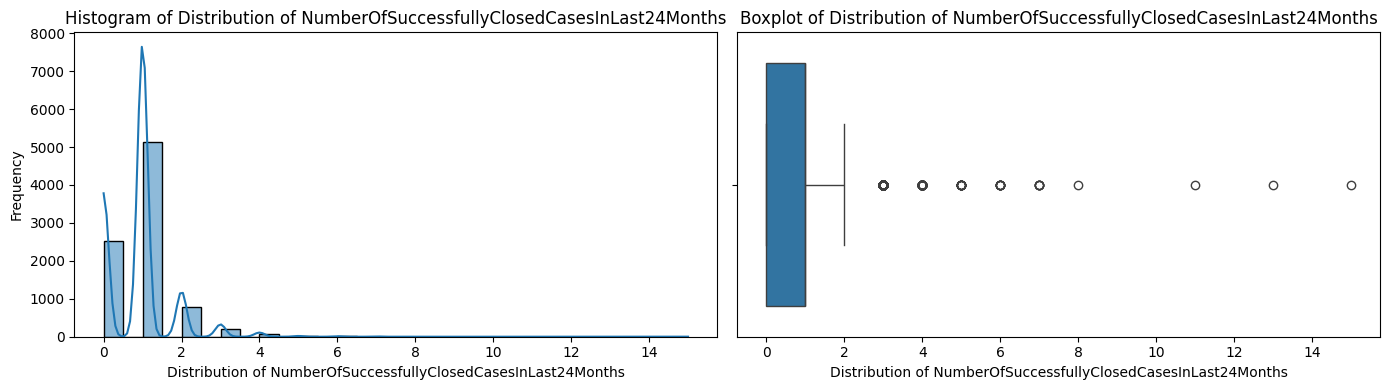

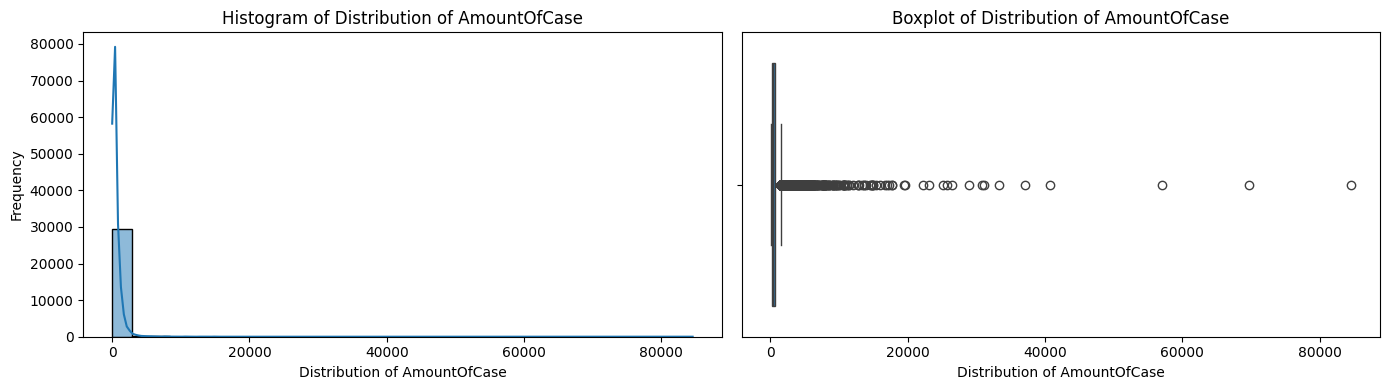

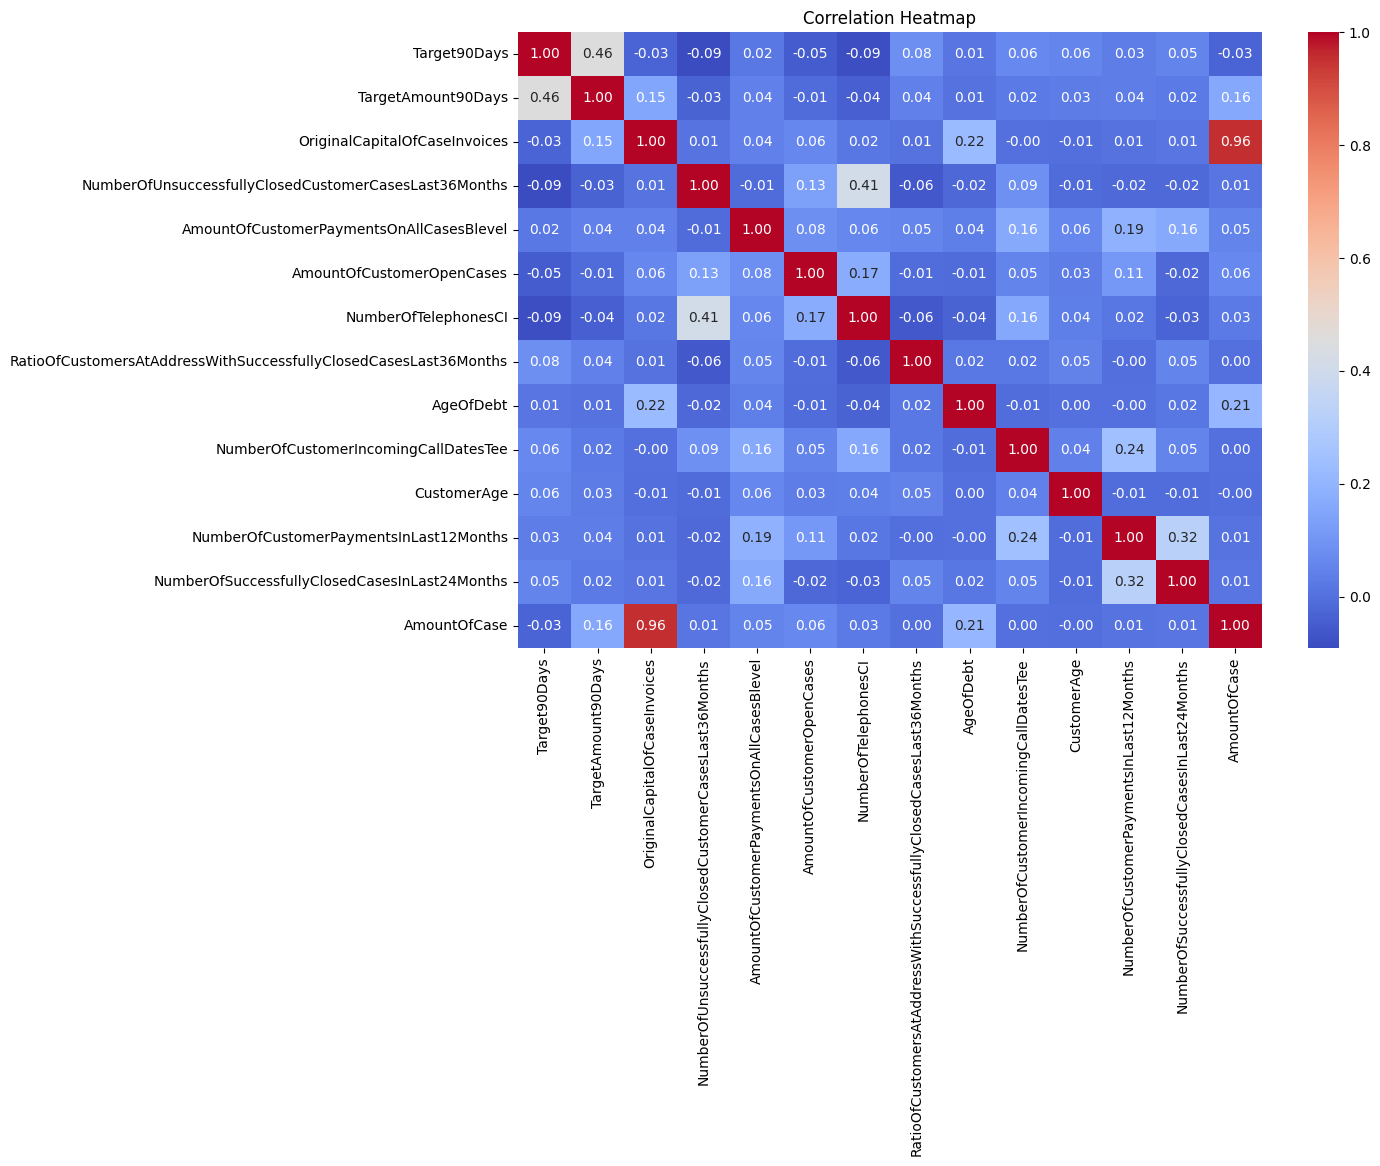

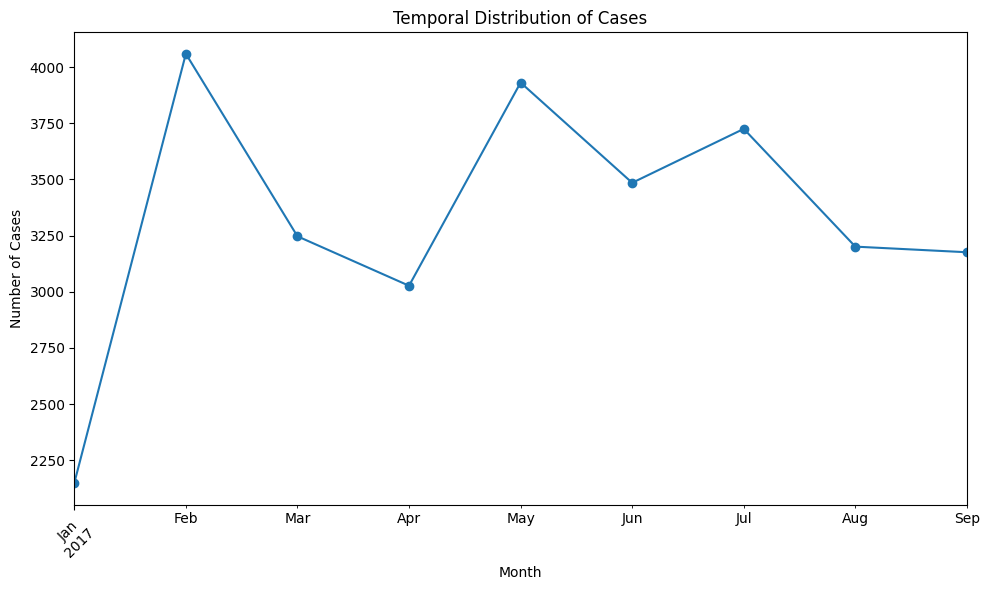

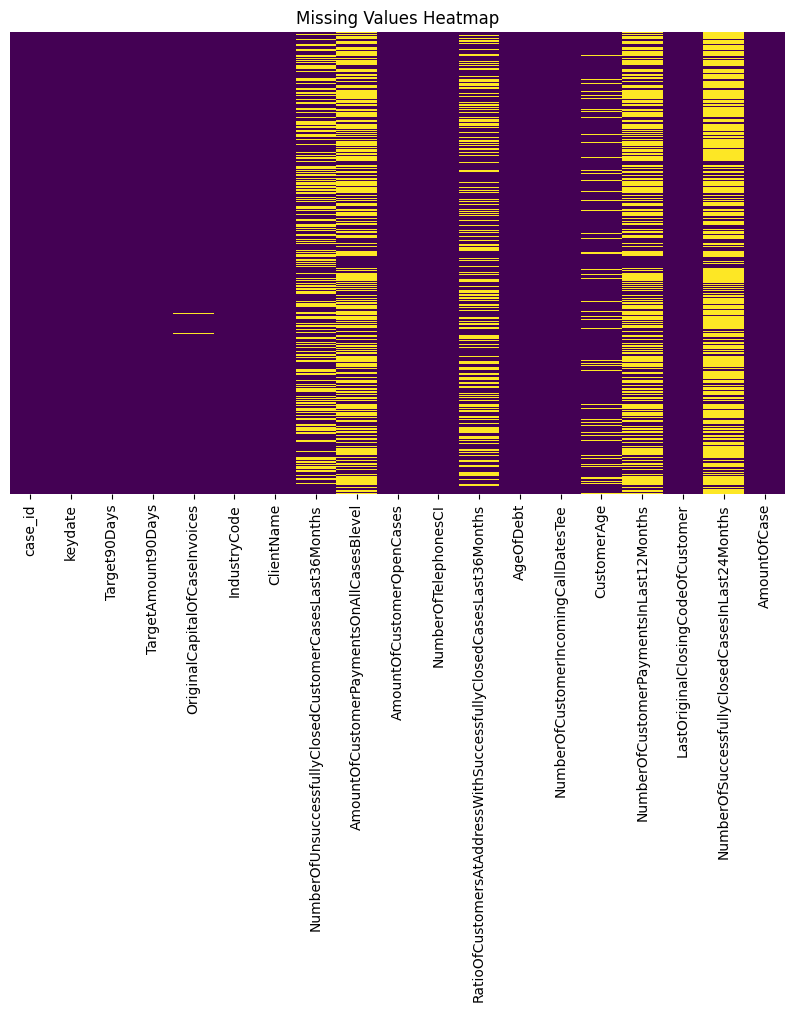

In [58]:
# Function to plot missing values heatmap 
def plot_missing_values_heatmap(dataframe):
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), cbar=False, cmap="viridis", yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()

# Function to create histograms and boxplots for numerical features
def plot_distribution(data, column, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    # Histogram
    sns.histplot(data[column], bins=30, ax=ax[0], kde=True)
    ax[0].set_title(f'Histogram of {title}')
    ax[0].set_xlabel(title)
    ax[0].set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(x=data[column], ax=ax[1])
    ax[1].set_title(f'Boxplot of {title}')
    ax[1].set_xlabel(title)

    plt.tight_layout()
    plt.show()

# Function to plot correlation heatmap
def plot_correlation_heatmap(correlation_matrix):
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

# Function to plot temporal distribution of cases
def plot_temporal_distribution(temporal_distribution):
    temporal_distribution.plot(figsize=(10, 6), marker='o', linestyle='-')
    plt.title("Temporal Distribution of Cases")
    plt.xlabel("Month")
    plt.ylabel("Number of Cases")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plotting distributions for numerical variables
for column in dataframe.columns:
    # Check if the column is numerical
    if dataframe[column].dtype in ['float64', 'int64'] and column != 'case_id':
        plot_title = f'Distribution of {column}'
        plot_distribution(dataframe, column, plot_title)

# Plot the correlation heatmap
plot_correlation_heatmap(dataframe.select_dtypes(include=[float]).corr())
# Plot the temporal distribution of cases
plot_temporal_distribution(temporal_distribution)
# Plot the missing values heatmap
plot_missing_values_heatmap(dataframe)

In [59]:
dataframe['Target90Days'].value_counts()

Target90Days
0.0    24938
1.0     5062
Name: count, dtype: int64

### Practical and Business Conclusions


#### Feature Engineering Decisions:

- Since number of payments/cases variables bound by a time window, contain `NA` values that imply that there never have been any values, while `0` mean that there have been no values within bounding period, instead of dropping the columns, I add a separate column indicating whether there has never been a payment and then handle NaN values by converting them to 0 for the specific payment/case-related variables.

- log transform skewed numericl variables

- outlier handling

- one-hot encode categorical variables


### 3. Work with missing values and draw some conclusions

In [60]:
# Calculate and display the percentage of missing values for each column
missing_percentage = dataframe.isnull().sum() / len(dataframe) * 100
print("Missing Data Percentage by Column:")
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

# Identify numerical and categorical columns for targeted imputation strategies
numerical_cols = dataframe.select_dtypes(include=[np.number]).columns
categorical_cols = dataframe.select_dtypes(include=['object', 'category']).columns

# Define lists of specific columns that require special handling for NA values
payment_related_cols = [
    'NumberOfCustomerPaymentsInLast12Months',
    'AmountOfCustomerPaymentsOnAllCasesBlevel'
]

case_related_cols = [
    'NumberOfUnsuccessfullyClosedCustomerCasesLast36Months',
    'NumberOfSuccessfullyClosedCasesInLast24Months',
    'RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months'
]

# Loop over numerical columns to apply the new strategy for NA values
for col in numerical_cols:
    if col in payment_related_cols and dataframe[col].isnull().any():
        # Add a separate column indicating whether there has never been a payment
        dataframe['NeverPaid'] = dataframe[col].isnull().astype(int)
        # Fill NaN values with 0 in the original column to indicate no payments within the period
        dataframe[col].fillna(0, inplace=True)
    elif col in case_related_cols and dataframe[col].isnull().any():
        # Add a separate column indicating whether there has never been a case
        dataframe['NeverCase'] = dataframe[col].isnull().astype(int)
        # Fill NaN values with 0 in the original column to indicate no cases within the period
        dataframe[col].fillna(0, inplace=True)
    elif dataframe[col].isnull().any():
        # For other numerical columns, use median imputation
        dataframe[col].fillna(dataframe[col].median(), inplace=True)

# Impute missing values for categorical columns with the mode
for col in categorical_cols:
    if dataframe[col].isnull().any():
        dataframe[col].fillna(dataframe[col].mode()[0], inplace=True)

# Re-check and display missing values percentage after imputation to ensure all have been addressed
print("\nMissing Data Percentage by Column After Imputation:")
print(dataframe.isnull().sum() / len(dataframe) * 100)

Missing Data Percentage by Column:
NumberOfSuccessfullyClosedCasesInLast24Months                       70.793333
NumberOfCustomerPaymentsInLast12Months                              56.506667
AmountOfCustomerPaymentsOnAllCasesBlevel                            56.420000
NumberOfUnsuccessfullyClosedCustomerCasesLast36Months               42.096667
RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months    34.670000
CustomerAge                                                          9.946667
OriginalCapitalOfCaseInvoices                                        0.083333
dtype: float64

Missing Data Percentage by Column After Imputation:
case_id                                                             0.0
keydate                                                             0.0
Target90Days                                                        0.0
TargetAmount90Days                                                  0.0
OriginalCapitalOfCaseInvoices                                  

/var/folders/p9/6x7xnkc9575f45rpxl6ygb0m0000gn/T/ipykernel_11336/1767862424.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe[col].fillna(dataframe[col].median(), inplace=True)
/var/folders/p9/6x7xnkc9575f45rpxl6ygb0m0000gn/T/ipykernel_11336/1767862424.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

### 3. Feature Engineering

In [61]:
# Define the features and target variable
X = dataframe.drop(['Target90Days', 'TargetAmount90Days', 'case_id'], axis=1)
y = dataframe['Target90Days'] 

# Split the dataset into training and testing sets
X['year'] = dataframe['keydate'].dt.year
X['month'] = dataframe['keydate'].dt.month
X['weekday'] = dataframe['keydate'].dt.weekday  # Monday=0, Sunday=6

# Define the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
temporal_features = ['year', 'month', 'weekday']
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Log Transformation for numerical features to normalize their distribution
for feature in numerical_features:
    dataframe[feature] = X[feature].apply(lambda x: np.log1p(x))

# Outlier Handling - capping with the 1st and 99th percentiles
for feature in numerical_features:
    lower_bound = X[feature].quantile(0.01)
    upper_bound = X[feature].quantile(0.99)
    X[feature] = np.clip(X[feature], lower_bound, upper_bound)

# Scale the numerical features
scaler = StandardScaler()
for feature in numerical_features:
    X[feature] = scaler.fit_transform(X[feature].values.reshape(-1, 1))

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer to apply transformations to specified columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('temp', 'passthrough', temporal_features),
        ('cat', one_hot_encoder, categorical_features)
    ])

# Create a pipeline with our preprocessor for clarity and structure
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the dataset
X_transformed = pipeline.fit_transform(X)

# Get feature names for one-hot encoded features
encoded_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()

# Combine all feature names
transformed_columns = numerical_features + temporal_features + list(encoded_feature_names)

# Create the transformed DataFrame
X_transformed


/var/folders/p9/6x7xnkc9575f45rpxl6ygb0m0000gn/T/ipykernel_11336/3613798430.py:17: RuntimeWarning: invalid value encountered in log1p
  dataframe[feature] = X[feature].apply(lambda x: np.log1p(x))


<30000x308 sparse matrix of type '<class 'numpy.float64'>'
	with 594316 stored elements in Compressed Sparse Row format>

In [62]:
# Convert the sparse matrix to a dense format (if memory allows)
dataframe_transformed_dense = pd.DataFrame(X_transformed.toarray(), columns=transformed_columns)
dataframe_transformed_dense

,OriginalCapitalOfCaseInvoices,NumberOfUnsuccessfullyClosedCustomerCasesLast36Months,AmountOfCustomerPaymentsOnAllCasesBlevel,AmountOfCustomerOpenCases,NumberOfTelephonesCI,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,AgeOfDebt,NumberOfCustomerIncomingCallDatesTee,CustomerAge,NumberOfCustomerPaymentsInLast12Months,...,LastOriginalClosingCodeOfCustomer_90,LastOriginalClosingCodeOfCustomer_91,LastOriginalClosingCodeOfCustomer_92,LastOriginalClosingCodeOfCustomer_93,LastOriginalClosingCodeOfCustomer_94,LastOriginalClosingCodeOfCustomer_95,LastOriginalClosingCodeOfCustomer_96,LastOriginalClosingCodeOfCustomer_97,LastOriginalClosingCodeOfCustomer_98,LastOriginalClosingCodeOfCustomer_99
0,-0.488271,0.875977,-0.460508,-0.222350,-0.531509,-0.646812,-0.002059,-0.394032,0.559388,-0.360720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.614856,-0.766326,0.117979,-0.441200,0.970920,-0.646812,0.080878,1.390263,0.722450,-0.360720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.799406,0.054826,-0.460508,-0.441200,-0.531509,-0.646812,4.898772,-0.394032,0.477857,-0.360720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.143600,-0.766326,-0.460508,-0.391496,-0.030700,2.846795,-0.680636,-0.394032,-1.234298,-0.360720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.660814,0.875977,-0.405553,-0.365000,1.471730,-0.646812,1.701922,-0.394032,-0.174392,-0.360720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-0.103439,-0.766326,2.228513,-0.218971,-0.030700,2.846795,-0.710795,-0.394032,-0.174392,2.462549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,-0.267953,-0.766326,-0.460508,6.190203,-0.531509,0.296462,0.095958,0.498116,-0.174392,-0.360720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,-0.136255,0.054826,-0.460508,-0.441200,-0.030700,-0.332388,0.035640,-0.394032,-0.092861,-0.360720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,0.064945,-0.766326,-0.180511,-0.441200,-0.531509,-0.646812,0.759455,-0.394032,0.967044,-0.360720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  4. Feature Importance

In [63]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model and adjust n_estimators and other parameters as necessary
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the sparse data
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Since the transformed dataset may not have column names, we create them based on the transformation
transformed_columns = numerical_features + temporal_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))

# Create a DataFrame to view the feature importances
features_df = pd.DataFrame({'Feature': transformed_columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Display the feature importances
features_df.head(10)

,Feature,Importance
11,AmountOfCase,0.101276
0,OriginalCapitalOfCaseInvoices,0.098178
8,CustomerAge,0.084833
6,AgeOfDebt,0.072905
2,AmountOfCustomerPaymentsOnAllCasesBlevel,0.060510
3,AmountOfCustomerOpenCases,0.056889
15,month,0.056749
4,NumberOfTelephonesCI,0.052488
5,RatioOfCustomersAtAddressWithSuccessfullyClose...,0.049166
16,weekday,0.041219


### Modeling: solve the problem and compare several models

* Random Forest
* Gradient Boosting
* XGBoost
* LightGMB
* Others

### Model Training with all Preprocessed Features

In [66]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Define the models to compare
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(random_state=42, force_col_wise=True, verbose=-1)  
}

# Loop through models, train, evaluate, and display extended metrics
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    
    # Displaying the evaluation metrics
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

Model: Random Forest
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      4993
         1.0       0.51      0.05      0.09      1007

    accuracy                           0.83      6000
   macro avg       0.67      0.52      0.50      6000
weighted avg       0.78      0.83      0.77      6000

Confusion Matrix:
[[4945   48]
 [ 958   49]]
--------------------------------------------------
Model: Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      4993
         1.0       0.59      0.04      0.07      1007

    accuracy                           0.83      6000
   macro avg       0.71      0.52      0.49      6000
weighted avg       0.80      0.83      0.77      6000

Confusion Matrix:
[[4965   28]
 [ 967   40]]
--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

         0.0       0.84      0.98     

/Users/bestricemossberg/Projects/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      4993
         1.0       0.58      0.03      0.07      1007

    accuracy                           0.83      6000
   macro avg       0.71      0.51      0.49      6000
weighted avg       0.79      0.83      0.77      6000

Confusion Matrix:
[[4968   25]
 [ 972   35]]
--------------------------------------------------
Model: LightGBM
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      4993
         1.0       0.54      0.07      0.12      1007

    accuracy                           0.83      6000
   macro avg       0.69      0.53      0.51      6000
weighted avg       0.79      0.83      0.78      6000

Confusion Matrix:
[[4935   58]
 [ 940   67]]
--------------------------------------------------


### Model training with K-fold cross-validation with the 10 most important features

In [67]:
# Assuming X_transformed and y are defined earlier
top_10_X = dataframe_transformed_dense[features_df['Feature'][:10]]

# Define the models to compare
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(random_state=42, force_col_wise=True, verbose=-1)  
}

# Define scorers for evaluation metrics
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1_score': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Loop through models and perform cross-validation
for name, model in models.items():
    scores = cross_validate(model, top_10_X, y, scoring=scorers, cv=10)
    
    print(f"Model: {name}")
    print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f} (+/- {np.std(scores['test_accuracy'])*2:.4f})")
    print(f"Precision: {np.mean(scores['test_precision']):.4f} (+/- {np.std(scores['test_precision'])*2:.4f})")
    print(f"Recall: {np.mean(scores['test_recall']):.4f} (+/- {np.std(scores['test_recall'])*2:.4f})")
    print(f"F1 Score: {np.mean(scores['test_f1_score']):.4f} (+/- {np.std(scores['test_f1_score'])*2:.4f})")
    print("-" * 50)


Model: Random Forest
Accuracy: 0.8276 (+/- 0.0048)
Precision: 0.7624 (+/- 0.0221)
Recall: 0.8276 (+/- 0.0048)
F1 Score: 0.7652 (+/- 0.0051)
--------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.8305 (+/- 0.0034)
Precision: 0.7610 (+/- 0.0789)
Recall: 0.8305 (+/- 0.0034)
F1 Score: 0.7573 (+/- 0.0049)
--------------------------------------------------
Model: XGBoost
Accuracy: 0.8225 (+/- 0.0063)
Precision: 0.7610 (+/- 0.0163)
Recall: 0.8225 (+/- 0.0063)
F1 Score: 0.7712 (+/- 0.0074)
--------------------------------------------------
Model: Logistic Regression
Accuracy: 0.8302 (+/- 0.0028)
Precision: 0.7520 (+/- 0.0534)
Recall: 0.8302 (+/- 0.0028)
F1 Score: 0.7573 (+/- 0.0054)
--------------------------------------------------
Model: LightGBM
Accuracy: 0.8295 (+/- 0.0026)
Precision: 0.7623 (+/- 0.0215)
Recall: 0.8295 (+/- 0.0026)
F1 Score: 0.7607 (+/- 0.0023)
--------------------------------------------------


### Comments on Results
- Random Forest shows solid performance with an accuracy of 82.76% and minimal variation across folds (±0.48%). Its precision and F1 score are relatively balanced, indicating a good trade-off between precision and recall. The slight variability in precision suggests differences in model performance across the folds, possibly due to the distribution of classes or the feature set's influence.

- Gradient Boosting slightly outperforms Random Forest in accuracy (83.05%) with comparable variability (±0.34%). However, it has a wider range in precision (±7.89%), which could indicate more fluctuation in how well the model identifies positive classes across different subsets of data. The F1 score is slightly lower than Random Forest, showing a small compromise in the balance between precision and recall.

- XGBoost has a slightly lower accuracy (82.25%) and higher variability in results (±0.63%) compared to Random Forest and Gradient Boosting. Its precision is consistent with Gradient Boosting, but the F1 score is higher, suggesting a better balance between precision and recall for this model. The increased variability across folds may reflect sensitivity to the data splits or the influence of outliers.

- Logistic Regression achieves comparable accuracy to Gradient Boosting (83.02%) with the least variation (±0.28%), indicating stable performance across different subsets of data. However, it has the widest range in precision (±5.34%), which might indicate inconsistency in identifying positive classes across folds. Despite this, its F1 score is similar to Gradient Boosting, maintaining a reasonable balance between precision and recall.

- LightGBM offers accuracy close to Gradient Boosting and Logistic Regression (82.95%) with minimal variability (±0.26%), indicating consistent performance across folds. Its precision and F1 score are closely matched to those of Random Forest, suggesting a similar balance between precision and recall. The slight variability in precision (±2.15%) is less than XGBoost and Logistic Regression, showing moderate stability in identifying positive classes.

#### Summary
Gradient Boosting and Logistic Regression slightly lead in accuracy, indicating strong overall performance. However, Logistic Regression shows the widest variability in precision, which may concern identifying positive classes consistently across different data subsets.
Random Forest and LightGBM display a good balance between precision and recall, as evidenced by their F1 scores, with Random Forest showing a bit more variability in precision.
XGBoost stands out for its balance (high F1 score) but shows higher variability in accuracy and precision, suggesting sensitivity to the dataset's splits or specific characteristics.